In [1]:
!pip install opendatasets

In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,Subset,random_split
from torchvision import datasets

from torchvision.io import read_image
import opendatasets as od
from PIL import Image
import torch.optim as optim
from google.colab import files
import os

In [3]:
od.download("https://www.kaggle.com/datasets/yashvrdnjain/hotdognothotdog")

100%|██████████| 166M/166M [00:02<00:00, 84.8MB/s]


In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
])

In [5]:
augmentation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class Mymodel(nn.Module):
    def __init__(self):
        super(Mymodel, self).__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(512,2)

    def forward(self, x):
        x = self.model(x)

        return x

In [8]:
model  = Mymodel()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 76.8MB/s]


In [9]:
from copy import copy
full_train_dataset = torchvision.datasets.ImageFolder(root='/content/hotdognothotdog/hotdog-nothotdog/train')
trainset, valset = random_split(full_train_dataset, [0.8, 0.2])
trainset.dataset = copy(full_train_dataset)
valset.dataset.transform = transform
trainset.dataset.transform = augmentation_transforms

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=0, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, num_workers=0, shuffle=False)

folder_2 = torchvision.datasets.ImageFolder(os.path.join('/content/hotdognothotdog/hotdog-nothotdog/test'), transform = transform)
test_loader = torch.utils.data.DataLoader(folder_2, batch_size=64, num_workers=0, shuffle=False)

In [10]:
torch.cuda.empty_cache()

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.0001)

In [12]:
len(train_loader)

38

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
num_epochs = 30
train_loss_arr = []
val_loss_arr = []
cor = []
pred = []
model.to(device)
for epoch in range(num_epochs):
    running_loss_train = 0.0
    model.train()
    for datas in train_loader:
      optimizer.zero_grad()
      inputs_train, labels_train = datas[0].to(device), datas[1].to(device)

      out = model(inputs_train)
      loss = criterion(out,labels_train)
      loss.backward()
      optimizer.step()
      running_loss_train += loss.item()

    running_loss_val = 0.0
    model.eval()
    for datas in val_loader:
      inputs_val,labels_val = datas[0].to(device),datas[1].to(device)
      with torch.no_grad():
        out = model(inputs_val)
        _, predicted = torch.max(out.data, 1)
        loss = criterion(out,labels_val)
        running_loss_val += loss.item()

        for label in labels_val:
          # print(label.cpu().numpy())
          cor.append(label.cpu().numpy())
        #   print("label", label)
        #   print()
        # print("---------")
        # print()
        for predict in predicted:
          pred.append(predict.cpu().numpy())
        #   print("predict:", predict)
        #   print()
        # print("---------")

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {(running_loss_train/len(inputs_train)):.4f}, Val Loss: {(running_loss_val/len(inputs_val)):.4f}')

    train_loss_arr.append((running_loss_train/len(inputs_train)))
    val_loss_arr.append((running_loss_val/len(inputs_val)))

    if ((running_loss_val/len(inputs_val)))==min(val_loss_arr):
      torch.save({
      'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, f'/content/model_v4_{(running_loss_val/len(inputs_val)):.4f}.pth')

    # print(cor)
    # print(pred)
    accuracy = accuracy_score(cor, pred)
    f1 = f1_score(cor, pred)
    precision = precision_score(cor, pred)
    recall = recall_score(cor, pred)

    print(f"Accuracy: {accuracy:.4f}, F1 score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print()
    print('-----------')
    print()

Epoch [1/30], Train Loss: 0.7719, Val Loss: 0.2619
Accuracy: 0.6500, F1 score: 0.6277, Precision: 0.7195, Recall: 0.5566

-----------

Epoch [2/30], Train Loss: 0.6610, Val Loss: 0.2226
Accuracy: 0.6942, F1 score: 0.6806, Precision: 0.7622, Recall: 0.6148

-----------

Epoch [3/30], Train Loss: 0.5826, Val Loss: 0.2028
Accuracy: 0.7261, F1 score: 0.7125, Precision: 0.8029, Recall: 0.6405

-----------

Epoch [4/30], Train Loss: 0.5264, Val Loss: 0.1812
Accuracy: 0.7512, F1 score: 0.7417, Precision: 0.8248, Recall: 0.6737

-----------

Epoch [5/30], Train Loss: 0.4806, Val Loss: 0.1660
Accuracy: 0.7717, F1 score: 0.7657, Precision: 0.8395, Recall: 0.7038

-----------

Epoch [6/30], Train Loss: 0.4368, Val Loss: 0.1571
Accuracy: 0.7864, F1 score: 0.7823, Precision: 0.8505, Recall: 0.7243

-----------

Epoch [7/30], Train Loss: 0.4162, Val Loss: 0.1465
Accuracy: 0.7988, F1 score: 0.7964, Precision: 0.8587, Recall: 0.7426

-----------

Epoch [8/30], Train Loss: 0.3925, Val Loss: 0.1417
Accu

In [14]:
print(train_loss_arr)
print(val_loss_arr)

[0.7719415239989758, 0.6610107319429517, 0.5826444299891591, 0.5264283875003457, 0.4805647199973464, 0.43677565548568964, 0.41620970144867897, 0.39249496813863516, 0.3755427272990346, 0.3553264639340341, 0.3510933215729892, 0.3418073388747871, 0.320384468883276, 0.31252929009497166, 0.30497761024162173, 0.2964948043227196, 0.29462389647960663, 0.28282491071149707, 0.2731845402158797, 0.27669437509030104, 0.2707831119187176, 0.2548189628869295, 0.25363780884072185, 0.24765569949522614, 0.25199895328842103, 0.2401005169376731, 0.2415256502572447, 0.23907302063889802, 0.22961815795861185, 0.22464321204461157]
[0.26189879328012466, 0.22256438558300337, 0.20279609287778536, 0.18123567352692285, 0.16595686102906862, 0.15710371111830077, 0.1464902125298977, 0.14166650424400964, 0.13622591644525528, 0.12865100180109343, 0.12544531747698784, 0.12059710857768853, 0.11862718500196934, 0.11504254055519898, 0.11159669856230418, 0.11031323857605457, 0.10970494896173477, 0.10852984959880511, 0.107210

In [15]:
import matplotlib.pyplot as plt

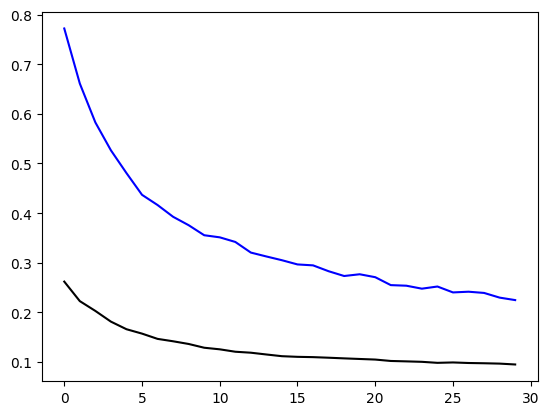

In [16]:
plt.plot(train_loss_arr, label = "train loss", color = "blue")
plt.plot(val_loss_arr, label = "val loss", color = "black")
plt.show()

In [ ]:
cor = []
pred = []
running_loss_test = 0
test_loss_arr = []
cnt = 0
mistake = 0
with torch.no_grad():
  model.eval()
  for data in test_loader:
    inputs_test,labels_test = data[0].to(device),data[1].to(device)
    out = model(inputs_test)
    loss = criterion(out,labels_test)
    running_loss_test += loss.item()
    _, predicted = torch.max(out.data, 1)
    cnt += 1
    # print(labels_test.cpu())
    # print(predicted.cpu())
    for ind in range(len(predicted.cpu())):
      if predicted[ind].cpu() != labels_test[ind].cpu():
        mistake += 1
        print(cnt, ind + 1)
        print('===========')



    for label in labels_test:
      cor.append(label.cpu().numpy())
    #   print("label", label)
    #   print()
    # print("---------")
    # print()
    for predict in predicted:
      pred.append(predict.cpu().numpy())
    #   print("predict:", predict)
    #   print()
    # print("---------")

    test_loss_arr.append(running_loss_test/len(inputs_test))

accuracy = accuracy_score(cor, pred)
f1 = f1_score(cor, pred)
precision = precision_score(cor, pred)
recall = recall_score(cor, pred)

print(f"Accuracy: {accuracy:.4f}, F1 score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
print()
print('-----------')
print()
print("Печалька ((((", mistake)

In [ ]:
print(test_loss_arr)

[0.0022880909964442253, 0.0056535922922194, 0.0072294819401577115, 0.0098581068450585, 0.013829801348038018, 0.014390650321729481, 0.015581657527945936, 0.019070129026658833, 0.023955017910338938, 0.028108638362027705, 0.45612237229943275]


In [18]:
classes = ("hotgot", "not_hot_dog")

In [20]:
from torch.autograd import Variable
def prediction(img_path, transformer):
  image = Image.open(img_path).convert('RGB')
  image_tensor = transformer(image)
  input_img = image_tensor.unsqueeze_(0)
  input_img = input_img.cuda()
  out = model(input_img.to(device))
  index = out.data.argmax()
  pred = classes[index]
  return pred

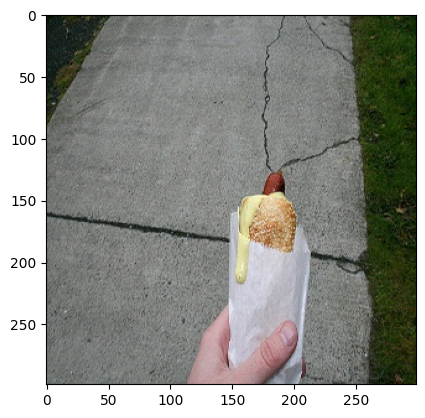

not_hot_dog


In [21]:
test_imgs = '/content/hotdognothotdog/hotdog-nothotdog/test/hotdog/1528.jpg'
img = plt.imread(test_imgs)
plt.imshow(img)
plt.show()
print(prediction(test_imgs, transform))

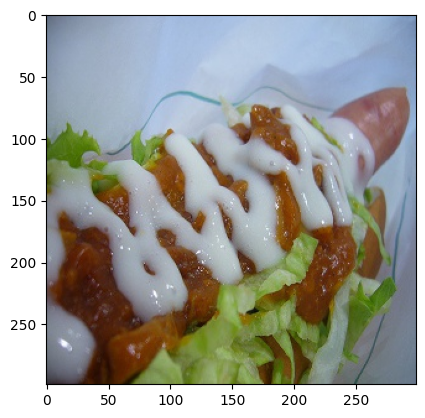

not_hot_dog


In [22]:
test_imgs = '/content/hotdognothotdog/hotdog-nothotdog/test/hotdog/1530.jpg'
img = plt.imread(test_imgs)
plt.imshow(img)
plt.show()
print(prediction(test_imgs, transform))

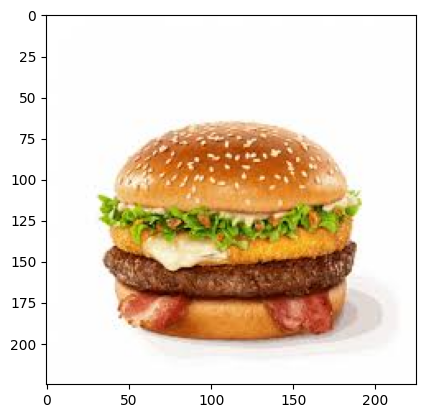

hotgot


In [30]:
test_imgs = '/content/burg.jpg'
img = plt.imread(test_imgs)
plt.imshow(img)
plt.show()
print(prediction(test_imgs, transform))

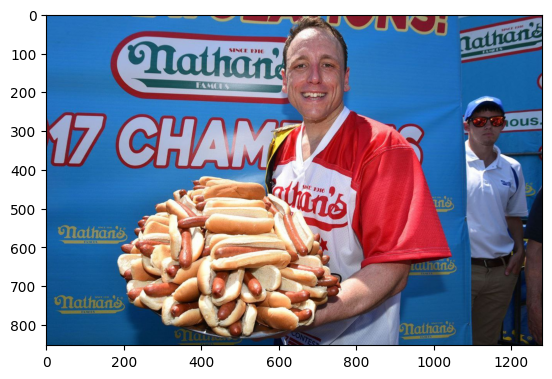

hotgot


In [26]:
test_imgs = '/content/chel.jpg'
img = plt.imread(test_imgs)
plt.imshow(img)
plt.show()
print(prediction(test_imgs, transform))

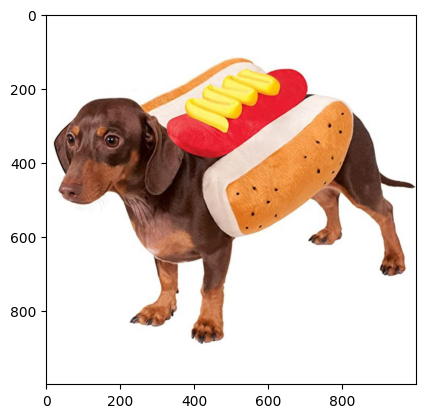

not_hot_dog


In [28]:
test_imgs = '/content/hotdog.jpg'
img = plt.imread(test_imgs)
plt.imshow(img)
plt.show()
print(prediction(test_imgs, transform))

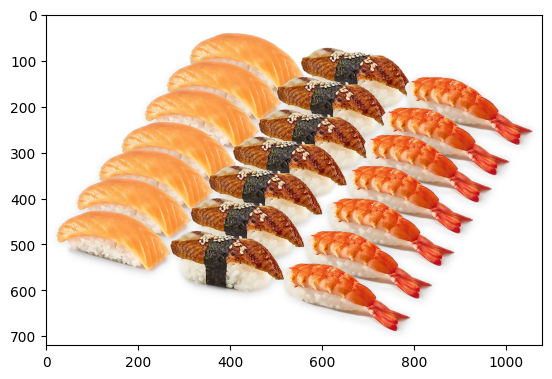

not_hot_dog


In [29]:
test_imgs = '/content/sushi.jpg'
img = plt.imread(test_imgs)
plt.imshow(img)
plt.show()
print(prediction(test_imgs, transform))